In [52]:
# imports
import pickle
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE 

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical, normalize
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import TensorBoard
from timeit import default_timer as timer
from tensorflow import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.callbacks import CSVLogger, ModelCheckpoint
import tensorflow as tf
# define colors (for readable prints)
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

#helper functions
def clean_column(column):
    column = column.strip(' ')
    column = column.replace('/', '_')
    column = column.replace(' ', '_')
    column = column.lower()
    return column

#define paths
ROOT_DIR = "C:/Users/jureb/Desktop/ml_testing/"
DATASET_DIR = ROOT_DIR + 'datasets/'
MODEL_DIR = ROOT_DIR + 'saved_models/'
DATASET_NAME = 'CICIDS2018'
PICKLE_DIR = DATASET_DIR + DATASET_NAME + '/'

In [53]:
print(bcolors.WARNING + "Loading pickle" + bcolors.ENDC)
with open(PICKLE_DIR + DATASET_NAME + '_optimized.pkl', 'rb') as f:
    df = pickle.load(f)

Loading pickle


In [54]:
df['Label'].value_counts()

Benign                   4664958
DDOS attack-HOIC          686012
FTP-BruteForce            193360
SSH-Bruteforce            187589
Infilteration              68871
DoS attacks-GoldenEye      41508
DoS attacks-Slowloris      10990
DDOS attack-LOIC-UDP        1730
Brute Force -Web             611
Brute Force -XSS             230
SQL Injection                 87
Name: Label, dtype: int64

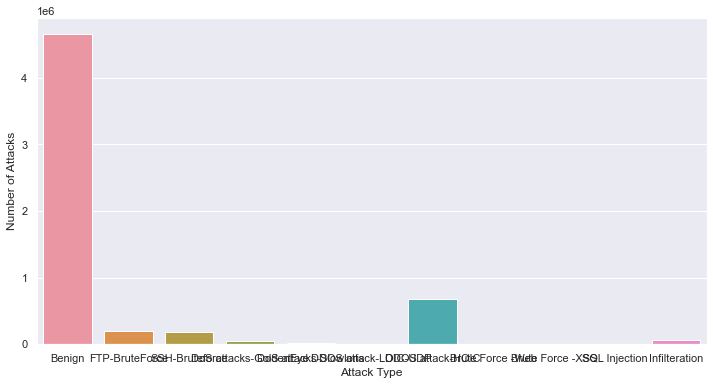

In [55]:
# make a plot number of labels
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='Label', data=df)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.show()

In [56]:
#df.isna().sum().to_numpy()
df.isna().sum().sum()

18562

In [57]:
df = df.dropna()
df.isna().sum().sum()

0

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5837384 entries, 0 to 613070
Data columns (total 79 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int32  
 1   Protocol           int8   
 2   Flow Duration      int64  
 3   Tot Fwd Pkts       int16  
 4   Tot Bwd Pkts       int16  
 5   TotLen Fwd Pkts    int32  
 6   TotLen Bwd Pkts    int32  
 7   Fwd Pkt Len Max    int32  
 8   Fwd Pkt Len Min    int32  
 9   Fwd Pkt Len Mean   float64
 10  Fwd Pkt Len Std    float64
 11  Bwd Pkt Len Max    int16  
 12  Bwd Pkt Len Min    int16  
 13  Bwd Pkt Len Mean   float64
 14  Bwd Pkt Len Std    float64
 15  Flow Byts/s        float64
 16  Flow Pkts/s        float64
 17  Flow IAT Mean      float64
 18  Flow IAT Std       float64
 19  Flow IAT Max       int64  
 20  Flow IAT Min       int32  
 21  Fwd IAT Tot        int32  
 22  Fwd IAT Mean       float32
 23  Fwd IAT Std        float64
 24  Fwd IAT Max        int32  
 25  Fwd IAT Min        

In [59]:
attack_group = {
    'Benign': 0,
    'DDOS attack-HOIC': 1,
    'DDOS attack-LOIC-UDP': 1,
    'DoS attacks-GoldenEye': 2,
    'DoS attacks-Hulk': 2,
    'DoS attacks-Slowloris': 2,
    'DoS attacks-SlowHTTPTest': 2,
    'FTP-BruteForce': 3,
    'SSH-Bruteforce': 3,
    'Brute Force -Web': 3,
    'Brute Force -XSS': 3,
    'SQL Injection': 4,
    'Infilteration': 4,
}
#Benign = 1
#DDoS = 2
#DoS = 3
#Bruteforce = 4
#Infilteration = 5

# Create grouped label column
df['Label'] = df['Label'].map(lambda x: attack_group[x])
print(df['Label'].value_counts())

0    4646811
1     687742
3     381784
4      68549
2      52498
Name: Label, dtype: int64


In [60]:
df.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,112641719,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,0
1,0,0,112641466,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,0
2,0,0,112638623,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,0
3,22,6,6453966,15,10,1239,2273,744,0,82.600000,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,0
4,22,6,8804066,14,11,1143,2209,744,0,81.642857,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,0


In [61]:
df = df.replace([np.inf, -np.inf], np.nan)
df.isna().sum().sum()

21552

In [62]:
df = df.dropna()
df.isna().sum().sum()

0

In [63]:
benign = df[df['Label'] == 0][:200000]
ddos = df[df['Label'] == 1][:200000]
dos = df[df['Label'] == 2][:200000]
bruteforce = df[df['Label'] == 3][:200000]
infilteration = df[df['Label'] == 4][:200000]

In [64]:
merge = [
    benign, ddos, dos, bruteforce, infilteration
]
df = pd.concat(merge)
del merge
df['Label'].value_counts()

0    200000
1    200000
3    200000
4     68323
2     52498
Name: Label, dtype: int64

In [65]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df.drop('Label', axis=1), df['Label'])

In [66]:
X_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 78 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1000000 non-null  int32  
 1   Protocol           1000000 non-null  int8   
 2   Flow Duration      1000000 non-null  int64  
 3   Tot Fwd Pkts       1000000 non-null  int16  
 4   Tot Bwd Pkts       1000000 non-null  int16  
 5   TotLen Fwd Pkts    1000000 non-null  int32  
 6   TotLen Bwd Pkts    1000000 non-null  int32  
 7   Fwd Pkt Len Max    1000000 non-null  int32  
 8   Fwd Pkt Len Min    1000000 non-null  int32  
 9   Fwd Pkt Len Mean   1000000 non-null  float64
 10  Fwd Pkt Len Std    1000000 non-null  float64
 11  Bwd Pkt Len Max    1000000 non-null  int16  
 12  Bwd Pkt Len Min    1000000 non-null  int16  
 13  Bwd Pkt Len Mean   1000000 non-null  float64
 14  Bwd Pkt Len Std    1000000 non-null  float64
 15  Flow Byts/s        1000000 non-nu

In [67]:
sampled_df = X_res.insert(78, 'Label', y_res)

In [68]:
df_final = X_res.copy()

In [69]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 79 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1000000 non-null  int32  
 1   Protocol           1000000 non-null  int8   
 2   Flow Duration      1000000 non-null  int64  
 3   Tot Fwd Pkts       1000000 non-null  int16  
 4   Tot Bwd Pkts       1000000 non-null  int16  
 5   TotLen Fwd Pkts    1000000 non-null  int32  
 6   TotLen Bwd Pkts    1000000 non-null  int32  
 7   Fwd Pkt Len Max    1000000 non-null  int32  
 8   Fwd Pkt Len Min    1000000 non-null  int32  
 9   Fwd Pkt Len Mean   1000000 non-null  float64
 10  Fwd Pkt Len Std    1000000 non-null  float64
 11  Bwd Pkt Len Max    1000000 non-null  int16  
 12  Bwd Pkt Len Min    1000000 non-null  int16  
 13  Bwd Pkt Len Mean   1000000 non-null  float64
 14  Bwd Pkt Len Std    1000000 non-null  float64
 15  Flow Byts/s        1000000 non-nu

In [70]:
print(bcolors.WARNING + "Saving as pickle" + bcolors.ENDC)
with open(PICKLE_DIR + DATASET_NAME + '_optimized_final.pkl', 'wb') as f:
    pickle.dump(df_final, f)

Saving as pickle
